In [89]:
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from PIL import Image
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import f1_score

%matplotlib inline

data_dir = "E:\Computer Science\UF MS in CS\Fall16\EMI\Projects\Project2\ProbeSet"
probeSetPath = "/Users/varunvyas/Desktop/ufl/semester 3/EMI/project/emi Project 2/Project2/ProbeSet"
galleryPath  = "/Users/varunvyas/Desktop/ufl/semester 3/EMI/project/emi Project 2/Project2/GallerySet"
genderFilePath = "/Users/varunvyas/Desktop/ufl/semester 3/EMI/project/emi Project 2/Project2/Gender.txt"
data_dir = galleryPath
data_dirTest = probeSetPath

os.chdir(data_dir)
#!ls

In [90]:
#converting from pgm to png
from glob import glob

%cd $data_dir

files=glob('*.pgm')
print 'number of files is',len(files)
count=0
for f in files:
    os.rename(f, f[:-4] + '.png')
    count  = count +1

    

/Users/varunvyas/Desktop/ufl/semester 3/EMI/project/emi Project 2/Project2/ProbeSet
number of files is 0


In [91]:
def image_grid(D,H,W,cols=10,scale=1):
    """ display a grid of images
        H,W: Height and width of the images
        cols: number of columns = number of images in each row
        scale: 1 to fill screen
    """
    n = np.shape(D)[0]
    print n
    rows = int(math.ceil((n+0.0)/cols))
    fig = plt.figure(1,figsize=[scale*20.0/H*W,scale*20.0/cols*rows],dpi=300)
    for i in range(n):
        plt.subplot(rows,cols,i+1)
        fig=plt.imshow(np.reshape(D[i,:],[H,W]), cmap = plt.get_cmap("gray"))
        plt.axis('off')

In [92]:
def create_filenames(data_dir):
    # loads the pictures into a list
    # data_dir: the CroppedYale folder
    # view_list: the views you wish to grab
    dir_list = os.listdir(data_dir)
    fileNames = []
    for f in dir_list:
            fileNames.append(str(f))
    return(fileNames)
filenames = create_filenames(galleryPath)
probeSetPathFilenames = create_filenames(probeSetPath)
probeSetPathFilenamesLength = len(probeSetPathFilenames)


In [93]:
# open image
im = Image.open(filenames[0]).convert("L")
# get original dimensions
H,W = np.shape(im)
print 'shape=',(H,W)

im_number = len(filenames)
# fill array with rows as image
# and columns as pixels
arr = np.zeros([im_number,H*W])
for i in range(im_number):
    im = Image.open(filenames[i]).convert("L")
    arr[i,:] = np.reshape(np.asarray(im),[1,H*W])

%cd $probeSetPath

probeSetPathOriginal = np.zeros([probeSetPathFilenamesLength,H*W])
for i in range(probeSetPathFilenamesLength):
    im = Image.open(probeSetPathFilenames[i]).convert("L")
    probeSetPathOriginal[i,:] = np.reshape(np.asarray(im),[1,H*W])
print probeSetPathOriginal.shape 

completeOriginalMatrix= np.concatenate(( arr , probeSetPathOriginal ))

print completeOriginalMatrix.shape
#image_grid(arr,H,W)
plt.show()
print arr


shape= (50, 50)
/Users/varunvyas/Desktop/ufl/semester 3/EMI/project/emi Project 2/Project2/ProbeSet
(200, 2500)
(300, 2500)
[[ 128.  128.  129. ...,  128.  128.  128.]
 [ 128.  131.  105. ...,  128.  128.  128.]
 [ 128.  130.  112. ...,  128.  128.  128.]
 ..., 
 [ 128.  131.  108. ...,  128.  128.  128.]
 [ 128.  131.  107. ...,  128.  128.  128.]
 [ 127.  130.  103. ...,  127.  127.  127.]]


(100, 2500)
(2500,)


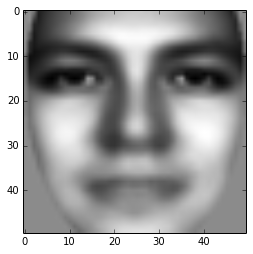

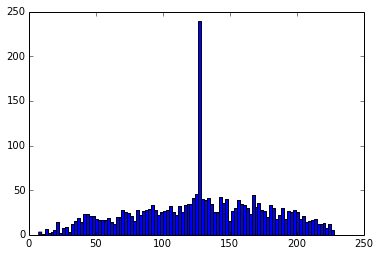

In [94]:
# let's find the mean_image
print arr.shape
mean_image = np.mean(arr, axis=0)
print np.shape(mean_image)
#mean_image = mean_image.reshape((np.size(mean_image),1))
#print np.shape(mean_image)
plt.imshow(np.reshape(mean_image,[H,W]), cmap = plt.get_cmap("gray"))
plt.figure()
plt.hist(mean_image,bins=100);
plt.show()

In [95]:
# centering the data (subtract mean face)
arr_norm = np.zeros([im_number, H*W])
print np.shape(arr)
print np.shape(mean_image)
arr_norm = arr - mean_image


(100, 2500)
(2500,)


8


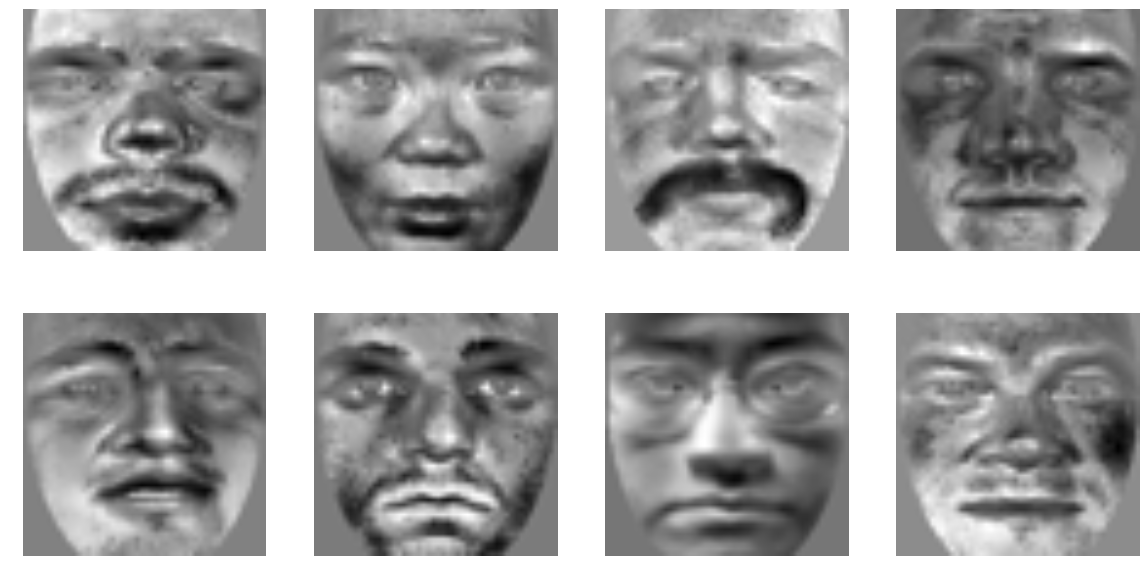

In [96]:
# plot the first 10 normalized faces
image_grid(arr_norm[:8,:],H,W,cols=4)
plt.show()

(100,)
0.906781845806
(100, 2500)


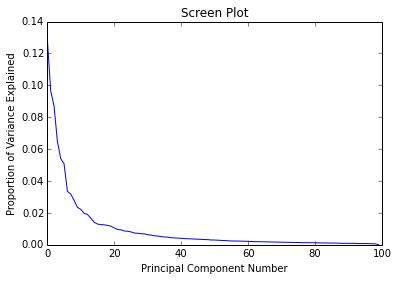

In [97]:
from sklearn.decomposition.pca import PCA
pca = PCA()
pca.fit(arr_norm)
# Let's make a screen plot
pve = pca.explained_variance_ratio_
print pve.shape
print sum(pve[0:45])
print arr_norm.shape
plt.plot(range(len(pve)), pve)
plt.title("Screen Plot")
plt.ylabel("Proportion of Variance Explained")
plt.xlabel("Principal Component Number")
plt.show()


(100, 2500)
8


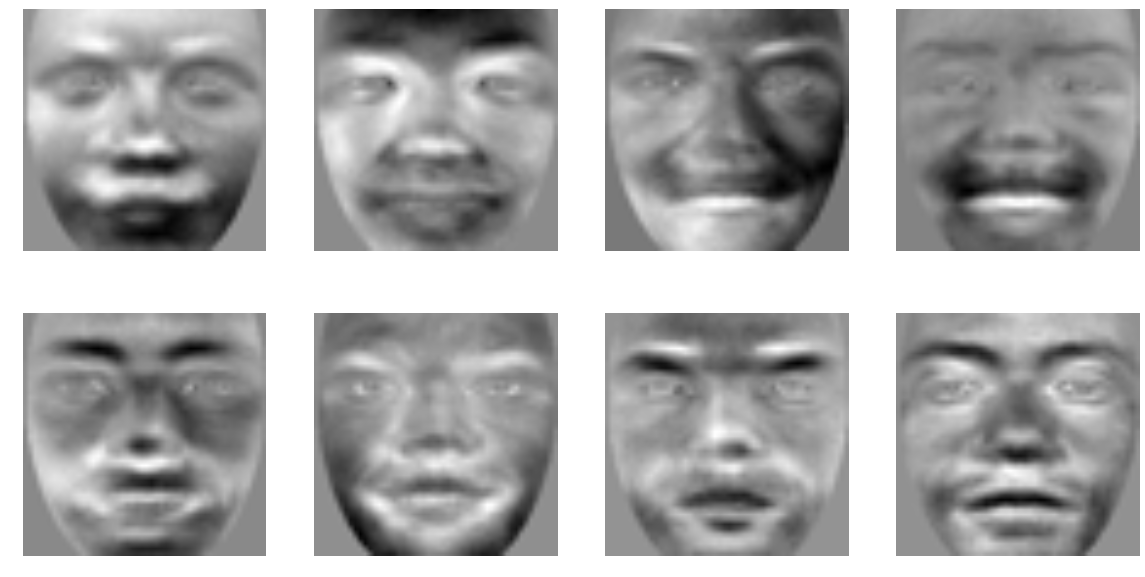

In [98]:
# eigenfaces
eigenfaces = pca.components_
print eigenfaces.shape
eigenfaces[:]
image_grid(eigenfaces[:8,:], H, W, cols=4)
plt.show()

In [99]:
# data_dirTest = "E:\Computer Science\UF MS in CS\Fall16\EMI\Projects\Project2\GallerySet"
os.chdir(probeSetPath)
filesTest=glob('*.png')
#numberOfPC = 3
im_numberTest = len(filesTest)

def getProjections(numberOfPC): 
    # fill array with rows as image
    # and columns as pixels
    arrTest = np.zeros([im_numberTest,H*W])
    projTest = np.zeros([im_numberTest,numberOfPC])
    projTrain = np.zeros([im_number,numberOfPC])
    for i in range(im_number):
        projTrain[i] = np.dot(eigenfaces[:numberOfPC,:],arr[i]).T
    for i in range(im_numberTest):
        im = Image.open(filesTest[i]).convert("L")
        arrTest[i,:] = np.reshape(np.asarray(im),[1,H*W])
        projTest[i] = np.dot(eigenfaces[:numberOfPC,:],arrTest[i]).T
    return (projTest,projTrain)



In [111]:
from sklearn.metrics.pairwise import euclidean_distances

def dunn_fast(points, labels):
    """ Dunn index - FAST (using sklearn pairwise euclidean_distance function)
    
    Parameters
    ----------
    points : np.array
        np.array([N, p]) of all points
    labels: np.array
        np.array([N]) labels of all points
    """
    distances = euclidean_distances(points)
    ks = np.sort(np.unique(labels))
    
    deltas = np.ones([len(ks), len(ks)])*1000000
    big_deltas = np.zeros([len(ks), 1])
    
    l_range = list(range(0, len(ks)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta_fast((labels == ks[k]), (labels == ks[l]), distances)
        
        big_deltas[k] = big_delta_fast((labels == ks[k]), distances)

    di = np.min(deltas)/np.max(big_deltas)
    return di

def delta_fast(ck, cl, distances):
    values = distances[np.where(ck)][:, np.where(cl)]
    values = values[np.nonzero(values)]

    return np.min(values)


def big_delta_fast(ci, distances):
    values = distances[np.where(ci)][:, np.where(ci)]
    #values = values[np.nonzero(values)]
            
    return np.max(values)



In [115]:
#small tests
from sklearn.metrics import pairwise_distances
genderArray = []
extraArray = []
def readGenderTextFile(genderFilePath ):
    with open(genderFilePath) as f:
        count = 0
        for line in f:            
            if("female" in line):
                genderArray.insert(count,0)
                extraArray.insert(count,0)
                extraArray.insert(count+1,0)
            else:
                genderArray.insert(count,1)
                extraArray.insert(count,1)
                extraArray.insert(count+1,1)
            count +=1
readGenderTextFile(genderFilePath)            
completeResultMatrix= np.concatenate(( genderArray , extraArray ))
calinski_harabaz_scoreList = []
f1_scoreListBinary = []
f1_scoreListMacro = []
dunnsIndexList = []
kmeansComplete = KMeans(n_clusters=2,max_iter=100, random_state=0).fit(completeOriginalMatrix)
print np.count_nonzero(kmeansComplete.labels_)
print metrics.calinski_harabaz_score(completeOriginalMatrix, kmeansComplete.labels_)
print dunn_fast(completeDataMatrix, kmeans.labels_)
# f1_score( completeOriginalMatrix, kmeansComplete.labels_, average='macro')
# f1_score( completeOriginalMatrix, kmeansComplete.labels_, average='binary')



for comp in range(10,101,10):

#     print '************************************************************************'

    # fig = plt.figure(1,figsize=[scale*20.0/H*W,scale*20.0/cols*rows],dpi=300)
    # for i in range(n):
    #     plt.subplot(rows,cols,i+1)
    #     fig=plt.imshow(np.reshape(D[i,:],[H,W]), cmap = plt.get_cmap("gray"))
    #     plt.axis('off')

#     print '************************************************************************'

    # image_grid(projTest[:8,:], H, W, cols=4)

    # print '************************************************************************'
#     completeOriginalMatrix
    
     
    (projTest,projTrain) = getProjections(comp)
    completeDataMatrix = np.concatenate( (projTest, projTrain) )
    print "component " + str(comp) + " " + str(np.count_nonzero(genderArray))

    kmeans = KMeans(n_clusters=2, random_state=0).fit(completeDataMatrix)
    dunnsIndexList.insert(comp, dunn_fast(completeDataMatrix, kmeans.labels_) )

    calinski_harabaz_scoreList.insert(comp,  metrics.calinski_harabaz_score(completeDataMatrix, kmeans.labels_) )
    
#     print "component " + str(comp) + " " + str(np.count_nonzero(kmeans.labels_))

    print "External Criteria F1-Score for Macro and binary "
    f1_scoreListMacro.insert(comp, f1_score( completeResultMatrix, kmeans.labels_, average='macro'))
  
    f1_scoreListBinary.insert(comp, f1_score( completeResultMatrix, kmeans.labels_, average='binary'))
    
print calinski_harabaz_scoreList

print f1_scoreListMacro

print f1_scoreListBinary

print dunnsIndexList

175
30.7905215687
0.101027372383
component 10 65
External Criteria F1-Score for Macro and binary 
component 20 65
External Criteria F1-Score for Macro and binary 
component 30 65
External Criteria F1-Score for Macro and binary 
component 40 65
External Criteria F1-Score for Macro and binary 
component 50 65
External Criteria F1-Score for Macro and binary 
component 60 65
External Criteria F1-Score for Macro and binary 
component 70 65
External Criteria F1-Score for Macro and binary 
component 80 65
External Criteria F1-Score for Macro and binary 
component 90 65
External Criteria F1-Score for Macro and binary 
component 100 65
External Criteria F1-Score for Macro and binary 
[57.269751533047355, 45.213602025004128, 40.814838042263801, 38.622691764967463, 37.250382768272395, 36.313973917184363, 35.64950328242243, 35.151376435981611, 34.782556189538269, 34.533047002801808]
[0.47767857142857151, 0.49236192714453586, 0.47767857142857151, 0.47767857142857151, 0.47767857142857151, 0.47767857

In [101]:
def dist(x,y):   
    return np.sqrt(np.sum((x-y)**2))
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score

genderArray = []
extraArray = []
totalArray = []
def readGenderTextFile(genderFilePath ):
    with open(genderFilePath) as f:
        count = 0
        for line in f:            
            if("female" in line):
                genderArray.insert(count,0)
                extraArray.insert(count,0)
                extraArray.insert(count+1,0)
            else:
                genderArray.insert(count,1)
                extraArray.insert(count,1)
                extraArray.insert(count+1,1)
            count +=1
def genderCompare(originalList, predictedList):
    genderTrueCounter = 0
    for i in range(len(originalList)):
        if( originalList[i] == predictedList[i]):
            genderTrueCounter +=1            
    return genderTrueCounter
            
readGenderTextFile(genderFilePath)            
# print " gender array " 
# print genderArray


for comp in range(10,101,10):
    min = np.zeros([im_numberTest,1])
    (projTest,projTrain) = getProjections(comp)
    
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(projTest)
    print "component " + str(comp) + " " + str(np.count_nonzero(kmeans.labels_))
    
    print "Kmeans Labels "  
    print kmeans.labels_
    print "count of what we got correct " 
    print genderCompare(genderArray, kmeans.labels_)
    print "Calinski Meterics " 
    from sklearn.metrics import pairwise_distances
    print metrics.calinski_harabaz_score(projTest, kmeans.labels_)
    print "External Criteria F1-Score for Macro and binary "
    print f1_score( genderArray, kmeans.labels_, average='macro')
    print f1_score( genderArray, kmeans.labels_, average='binary')

    
    for j in range(im_numberTest):
        min[j] = 0
        minDistance = float("inf")
        for i in range(im_number):
            distance = dist(projTest[j],projTrain[i])
            if distance < minDistance:
                min[j] = i
                minDistance = distance
    fileNamesTest = create_filenames(data_dirTest)   
    import re
    m = re.search(r'\d+', fileNamesTest[(int(round(min[1])))])
    #countArr = np.zeros([10,1])
    count = 0
    for k in range(im_numberTest):
        if re.search(r'\d+', fileNamesTest[k]).group(0) == re.search(r'\d+', filenames[(int(round(min[k])))]).group(0):
                count +=1
#     print "count " + str(count)            
    print count

component 10 117
Kmeans Labels 
[0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1
 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1
 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1
 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1
 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1]
count of what we got correct 
51
Calinski Meterics 
40.531013956
External Criteria F1-Score for Macro and binary 


ValueError: Found input variables with inconsistent numbers of samples: [100, 200]

In [ ]:
fileNamesTest = create_filenames(probeSetPath) 
arrTest = np.zeros([im_numberTest,H*W])

for i in range(im_numberTest):
    im = Image.open(fileNamesTest[i]).convert("L")
    arrTest[i,:] = np.reshape(np.asarray(im),[1,H*W])
#print arrTest
#print arr

for j in range(im_numberTest):
        min[j] = 0
        minDistance = float("inf")
        for i in range(im_number):
            distance = dist(arrTest[j],arr[i])
            if distance < minDistance:
                min[j] = i
                minDistance = distance 

print min                
                
import re
m = re.search(r'\d+', fileNamesTest[(int(round(min[1])))])
#countArr = np.zeros([10,1])

count = 0
for k in range(im_numberTest):
    if re.search(r'\d+', fileNamesTest[k]).group(0) == re.search(r'\d+', filenames[(int(round(min[k])))]).group(0):
            count +=1
print count            


In [ ]:
#image_grid(arr,H,W)
image_grid(arrTest,H,W)
plt.show()
